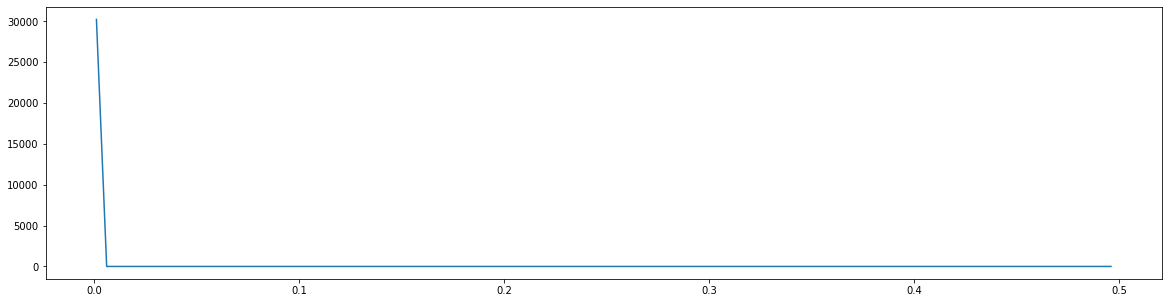

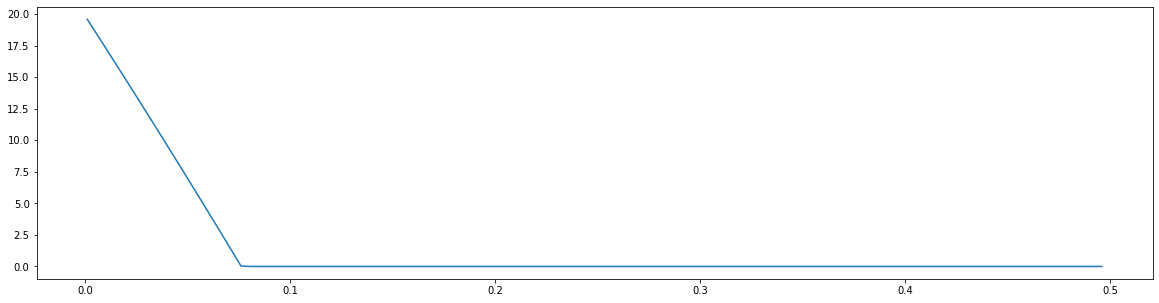

In [7]:
import sys
import os
import glob
sys.path.append('../../..')

from model import processing
# price_list = processing.import_binance_prices(assets=['USDC'], start_date='Jul 23 2022', days=200)
# print(price_list[0:10])

from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, price, usd_price, dynamicadd_asset_fee, dynamicadd_lrna_fee, cash_out_omnipool
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, back_and_forth, trade_to_slippage, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

assets = {
    'USDC': {'usd price': 1, 'weight': 0.5},
    'HDX': {'usd price': 0.5, 'weight': 0.5}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

states = [
    GlobalState(
        pools={
            'omnipool': OmnipoolState(
                tokens={
                    tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
                },
                preferred_stablecoin='USDC',
                # oracles={'fee_raise': 50},  # , 'fee_lower': 7200},
                lrna_fee=0,
                asset_fee=0,
            )
        },
        agents={
            'Trader': Agent(
                holdings={tkn: 1000000000 for tkn in list(assets.keys()) + ['LRNA']},
                trade_strategy=trade_to_slippage(pool_id='omnipool', slippage=0.005, trade_chance=1)
            ),
        },
        external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
        archive_all = False
    ),
    GlobalState(
        pools={
            'omnipool': OmnipoolState(
                tokens={
                    tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
                },
                preferred_stablecoin='USDC',
                # oracles={'fee_raise': 50},  # , 'fee_lower': 7200},
                lrna_fee=0,
                asset_fee=0,
            )
        },
        agents={
            'Trader': Agent(
                holdings={tkn: 1000000000 for tkn in list(assets.keys()) + ['LRNA']},
                trade_strategy=price_sensitive_trading(pool_id='omnipool', max_volume_usd=10, price_sensitivity=10, trade_frequency=1)
            ),
        },
        external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
        archive_all = False
    )
]

trade_volume = {}
for state in states:
    trade_volume[state] = []
    for i in range(100):
        state.pools['omnipool'].lrna_fee = i / 1000 + 0.001
        state.pools['omnipool'].asset_fee = i / 200 + 0.001
        events = run.run(state.copy(), time_steps=2, silent=True)
        trade_volume[state].append(
            sum([state.external_market[tkn] * volume for tkn, volume in events[-1].pools['omnipool'].volume_in.items()]) 
            + sum([state.external_market[tkn] * volume for tkn, volume in events[-1].pools['omnipool'].volume_out.items()])
        )

for state in states:
    plt.figure(figsize=(20, 5))
    plt.plot([i / 200 + 0.001 for i in range(100)], trade_volume[state])
